In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utilsforecast.preprocessing import fill_gaps

Suntracer temperature data

In [5]:
# Load the data
data = pd.read_csv('data/wot-data-db.interactions-datas-suntracer-rain.csv')

data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.set_index('timestamp')

df = data[['data.value']]

df.describe().transpose()

,count,unique,top,freq
data.value,473,2,True,237


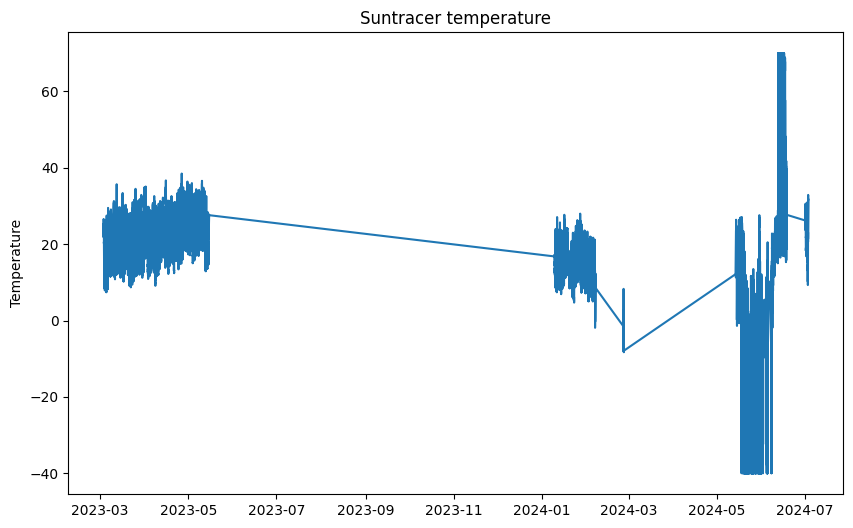

In [314]:
# Plot the data
plt.figure(figsize=(10,6))
plt.plot(df)
plt.title('Suntracer temperature')
plt.ylabel('Temperature')
plt.show()

Los datos completos del Suntracer no son favorables a ser tratados directamente dentro del modelo debido a distintos problemas:
    - Datos extremos y, probablemente, erróneos como temperaturas de -40º o 70º
    - Ausencia de datos por largos periodos temporales, como lo son del 2023-05-16 al 2024-01-09

In [315]:
# Check for data between 2024-03-01 and 2024-05-02 to see the lowest temperature
test = df['2024-05-01':'2024-06-02']
test.sort_values(by='data.value', ascending=True).head(10)


,data.value
timestamp,
2024-05-20 07:43:05+00:00,-40.0
2024-05-24 23:30:33+00:00,-40.0
2024-05-24 23:32:33+00:00,-40.0
2024-05-22 00:46:51+00:00,-40.0
2024-05-22 00:43:51+00:00,-40.0
2024-05-24 23:40:32+00:00,-40.0
2024-05-24 23:43:32+00:00,-40.0
2024-05-22 00:50:50+00:00,-40.0
2024-05-22 00:38:51+00:00,-40.0


In [316]:
# Check for data between 2024-06-01 and 2024-07-03 to see the highest temperature
test = df['2024-06-01':'2024-07-03']
test.sort_values(by='data.value', ascending=False).head(10)

,data.value
timestamp,
2024-06-12 23:37:35+00:00,70.0
2024-06-13 15:52:54+00:00,70.0
2024-06-13 16:18:52+00:00,70.0
2024-06-13 16:15:52+00:00,70.0
2024-06-13 16:11:52+00:00,70.0
2024-06-14 07:48:16+00:00,70.0
2024-06-14 08:08:14+00:00,70.0
2024-06-13 15:59:53+00:00,70.0
2024-06-13 15:55:54+00:00,70.0


In [317]:
# Check for data between 2023-05-16 and 2024-01-08 to prove the missing values
test_long_data_missing = df['2023-05-16':'2024-01-08']
test_long_data_missing.sort_values(by='timestamp', ascending=True).head(10)

,data.value
timestamp,


In [318]:
# Check for data between 2024-02-27 and 2024-05-13 to prove the missing values
test_long_data_missing = df['2024-02-27':'2024-05-13']
test_long_data_missing.sort_values(by='timestamp', ascending=True).head(10)

,data.value
timestamp,


In [319]:
# Check for data between 2024-06-18 and 2024-07-01 to prove the missing values and values are taken weirdly
test_long_data_missing = df['2024-06-18':'2024-07-01']
test_long_data_missing.sort_values(by='timestamp', ascending=True).head(10)

,data.value
timestamp,
2024-06-18 00:00:11+00:00,36.5
2024-06-18 00:01:11+00:00,34.4
2024-06-18 00:02:11+00:00,17.4
2024-06-18 00:03:11+00:00,34.9
2024-06-18 00:04:10+00:00,33.6
2024-06-18 00:05:10+00:00,17.0
2024-06-18 00:06:10+00:00,32.0
2024-06-18 00:07:10+00:00,31.1
2024-06-18 00:08:10+00:00,17.3


In [320]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
data.value,134665.0,17.323239,15.474028,-40.0,13.0,18.2,24.4,70.0


Debido a todos estos problemas, se ha optado por tomar únicamente el tramo entre 2023-03 hasta 2023-05

In [321]:
reduced_df = df['2023-03-01':'2023-05-15']
reduced_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
data.value,72681.0,21.250287,6.030285,7.4,16.1,20.9,26.2,38.5


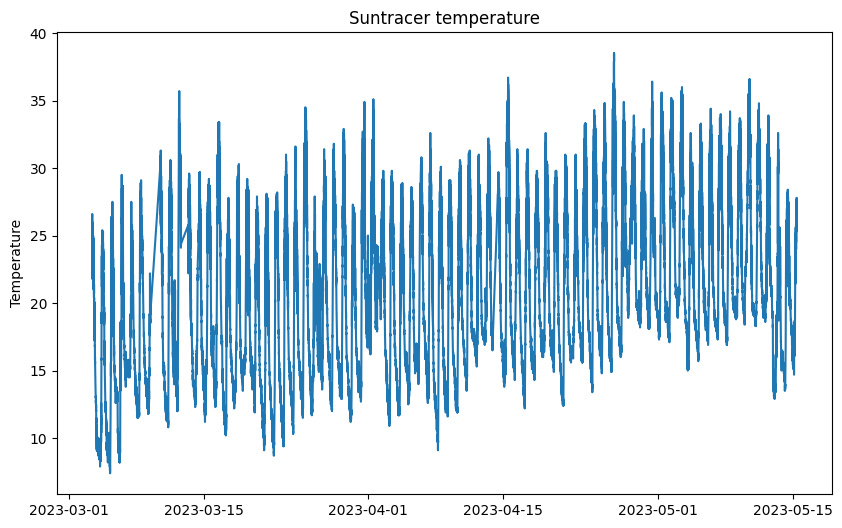

In [322]:
# Plot the data
plt.figure(figsize=(10,6))
plt.plot(reduced_df)
plt.title('Suntracer temperature')
plt.ylabel('Temperature')
plt.show()

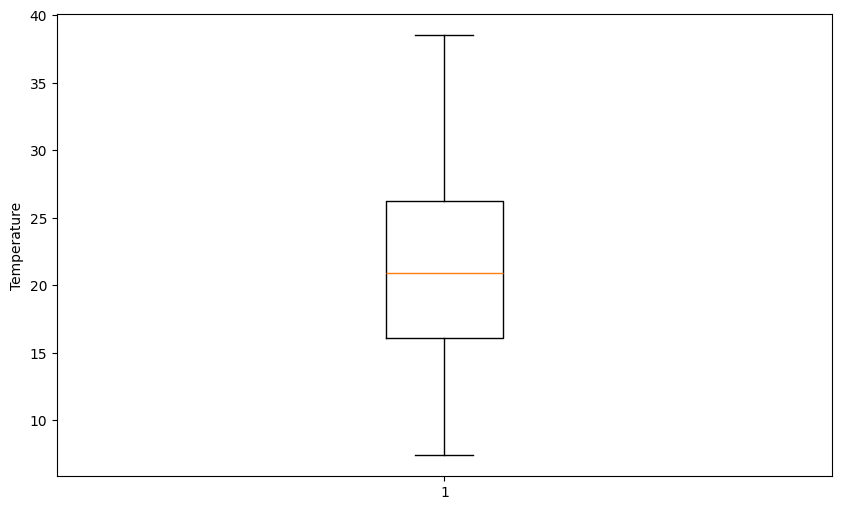

In [323]:
# Boxplot
plt.figure(figsize=(10,6))
plt.boxplot(reduced_df['data.value'])
plt.ylabel('Temperature')
plt.show()


In [324]:
# Mini tratamiento de datos para mejorar la legibilidad de la tabla
reduced_df = reduced_df.rename(columns={'data.value': 'temperature'})
reduced_df = reduced_df.reset_index()
# Cambia el timestamp para que solo muestre hasta minutos
reduced_df['timestamp'] = reduced_df['timestamp'].dt.strftime('%Y-%m-%d %H:%M')
reduced_df.head()

,timestamp,temperature
0,2023-03-03 09:30,22.7
1,2023-03-03 09:31,22.2
2,2023-03-03 09:32,21.8
3,2023-03-03 09:33,22.1
4,2023-03-03 09:34,22.6


In [360]:
# Quiero probar a ver que tal sale el fill gaps de eso
print("Original data: ", len(reduced_df), "rows")
gaps = reduced_df[['timestamp', 'temperature']]
gaps.rename(columns={'timestamp': 'ds', 'temperature': 'y'}, inplace=True)
gaps['ds'] = pd.to_datetime(gaps['ds'])
gaps['unique_id'] = 'suntracer_temperature'
gaps = gaps[['unique_id', 'ds', 'y']]
test_fill_gaps = fill_gaps(gaps, freq='min')
print("Filled data: ", len(test_fill_gaps), "rows")



test_fill_gaps['y'] = test_fill_gaps['y'].interpolate(method='linear', limit_direction='both')
test_fill_gaps.isna().sum() # Check for missing values

Original data:  72584 rows
Filled data:  105133 rows


unique_id    0
ds           0
y            0
dtype: int64

Testing with TimeGPT without treating the data

In [325]:
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(
    api_key='nixtla-tok-0Xy1KrijueISj5UTfxyGuceKmM8KuLVGO1b92Xs1i3DZB0bUvmr2CjtSqjHn9UlTQokrx3Wl8C7dnOlE')
nixtla_client.validate_api_key()

INFO:nixtla.nixtla_client:Happy Forecasting! :), If you have questions or need support, please email ops@nixtla.io


True

In [326]:
# Buscar por timestamps que se repitan y combinarlos con su media. Dejar la tabla solo con las columnas timestamp y temperature

reduced_df = reduced_df.groupby('timestamp').mean().reset_index()

reduced_df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
temperature,72584.0,21.248933,6.029847,7.4,16.1,20.9,26.2,38.5


In [327]:
# Buscar por timestamps que se repitan
reduced_df

,timestamp,temperature
0,2023-03-03 09:30,22.7
1,2023-03-03 09:31,22.2
2,2023-03-03 09:32,21.8
3,2023-03-03 09:33,22.1
4,2023-03-03 09:34,22.6
...,...,...
72579,2023-05-15 09:38,27.8
72580,2023-05-15 09:39,26.7
72581,2023-05-15 09:40,26.8
72582,2023-05-15 09:41,26.7


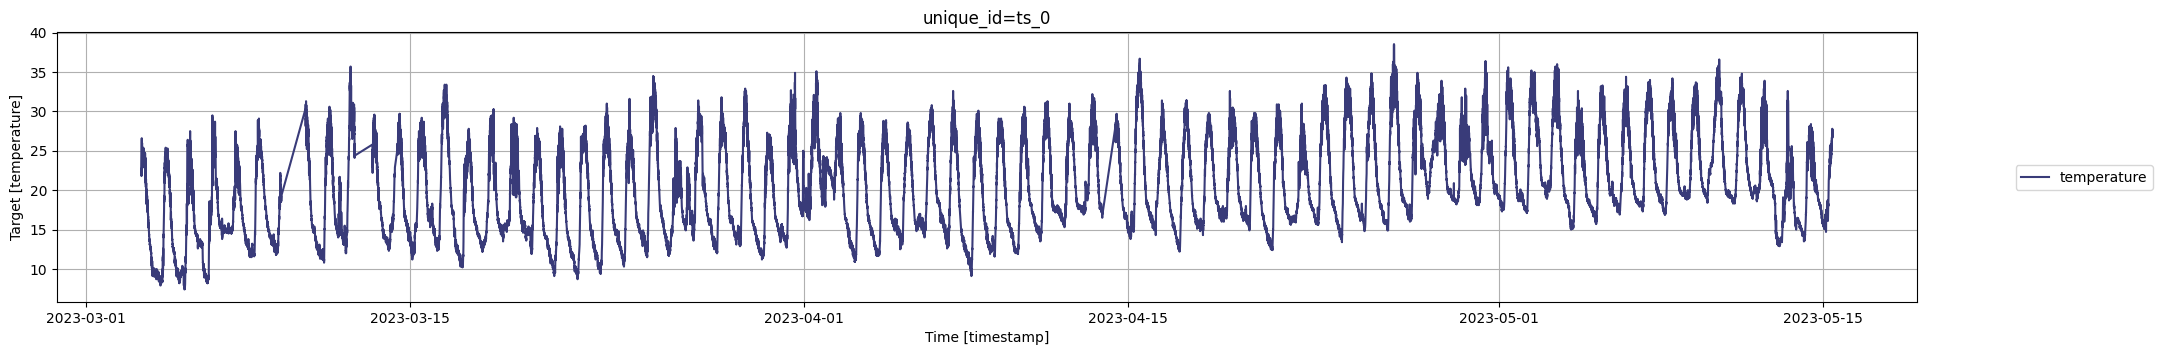

In [328]:
nixtla_client.plot(reduced_df,time_col='timestamp', target_col='temperature')

In [339]:
#Separate to training and test data to predict the temperature
train = reduced_df.groupby('timestamp').tail(15)
test = reduced_df.groupby('timestamp').apply(lambda x: x.iloc[:-15]).reset_index(drop=True)

C:\Users\IvO\AppData\Local\Temp\ipykernel_25824\3126183753.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test = reduced_df.groupby('timestamp').apply(lambda x: x.iloc[:-15]).reset_index(drop=True)


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


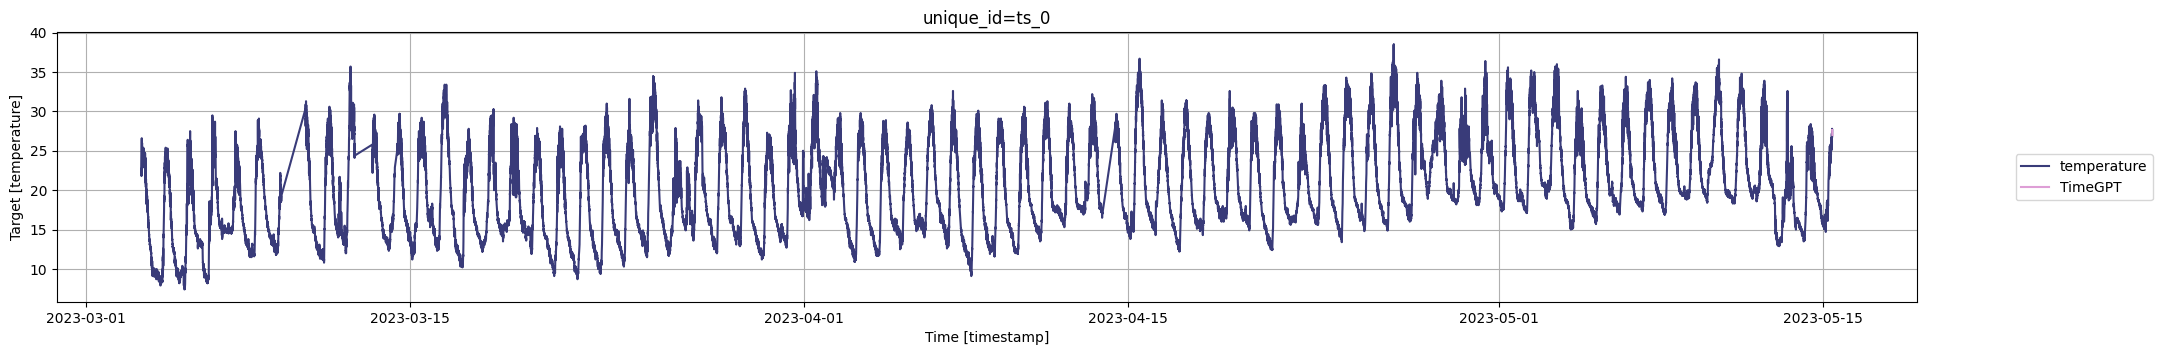

In [340]:
# Forecast next 2 hours
forecast = nixtla_client.forecast(
    df=train, 
    h=15, 
    freq='min',
    finetune_steps=10,
    finetune_loss='mae', 
    time_col='timestamp', 
    target_col='temperature')
nixtla_client.plot(reduced_df, forecast, time_col='timestamp', target_col='temperature')

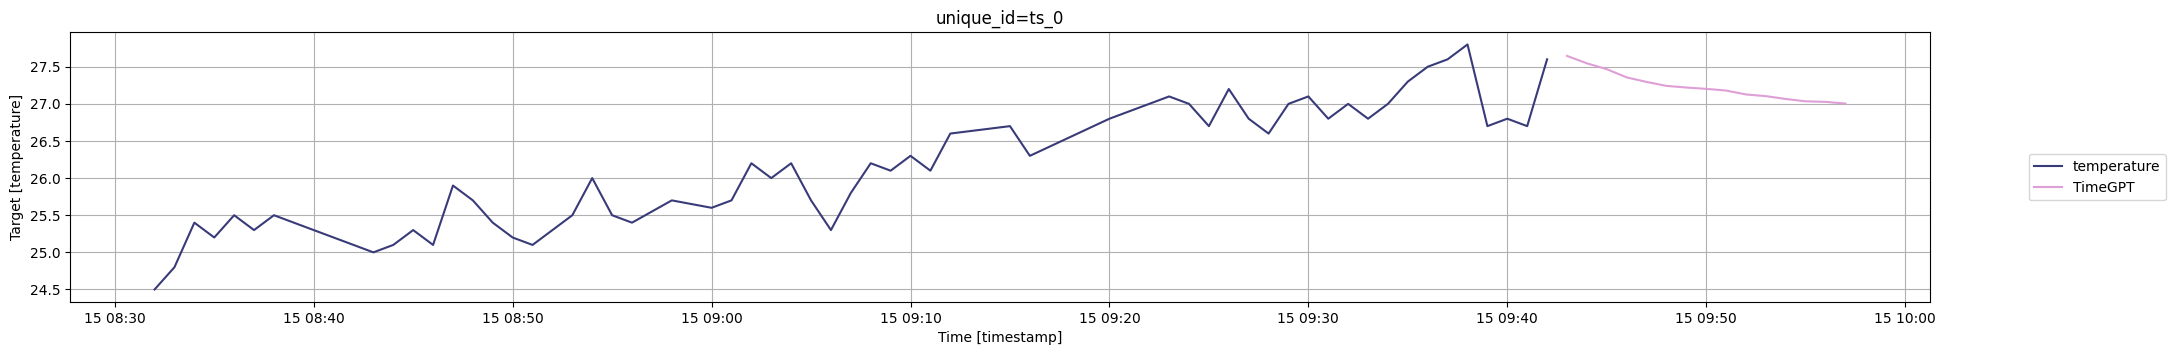

In [341]:
nixtla_client.plot(train, forecast, time_col='timestamp', target_col='temperature', max_insample_length=60)

Detección de anomalias dentro de TimeGPT

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...


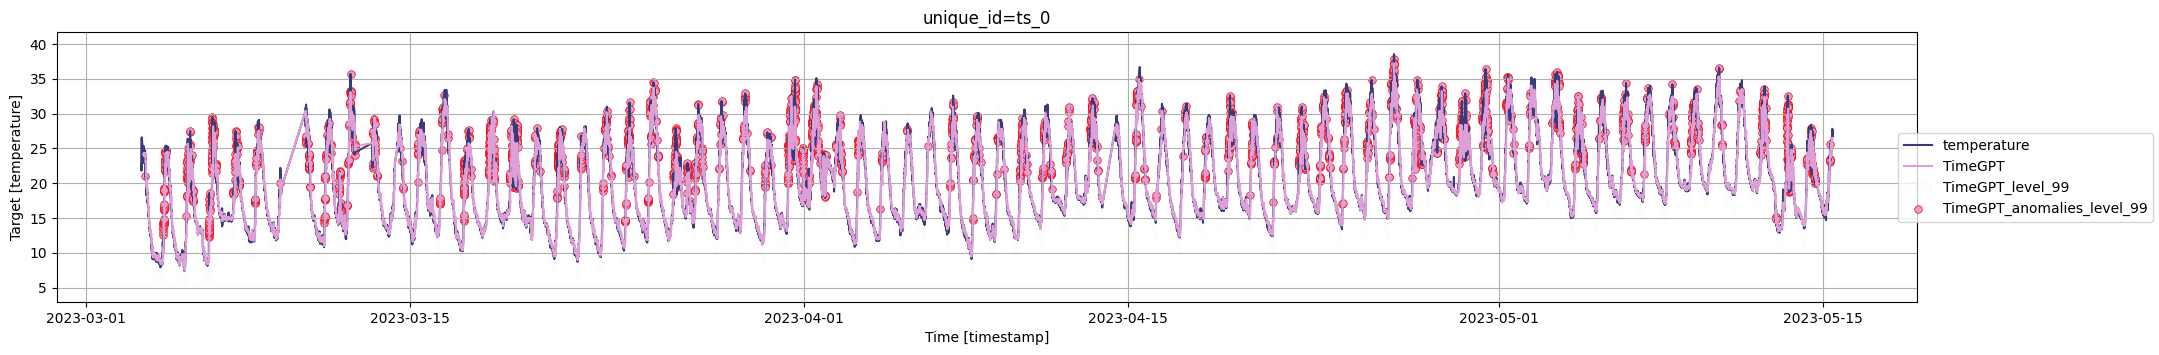

In [342]:
anomalies_df = nixtla_client.detect_anomalies(train, time_col='timestamp', target_col='temperature', freq='min')
nixtla_client.plot(train, anomalies_df, time_col='timestamp', target_col='temperature')

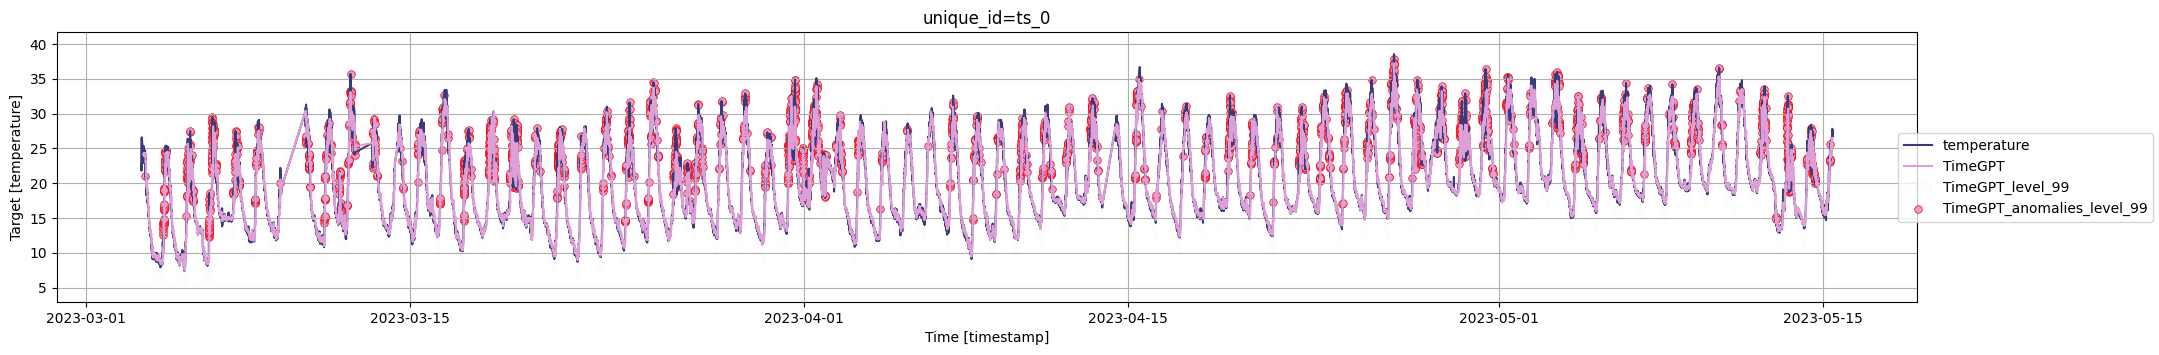

In [333]:
nixtla_client.plot(train, anomalies_df, time_col='timestamp', target_col='temperature', max_insample_length=60)

In [343]:
forecast['timestamp'] = pd.to_datetime(forecast['timestamp'])


test = pd.merge(test, forecast, on='timestamp', how='left')



In [371]:
train_without_gaps_df = test_fill_gaps[:-1440]
test_without_gaps_df = test_fill_gaps[-1440:]

In [379]:
forecast_with_gaps = nixtla_client.forecast(
    df = train_without_gaps_df,
    h = 1440,
    finetune_steps=1000,
    finetune_loss='mae',
    time_col='ds',
    target_col='y',
    model='timegpt-1-long-horizon')
nixtla_client.plot(train_without_gaps_df, forecast_with_gaps, time_col='ds', target_col='y')

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: min
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Attempt 1 failed...
INFO:nixtla.nixtla_client:Attempt 2 failed...
INFO:nixtla.nixtla_client:Attempt 3 failed...
INFO:nixtla.nixtla_client:Attempt 4 failed...
INFO:nixtla.nixtla_client:Attempt 5 failed...
INFO:nixtla.nixtla_client:Attempt 6 failed...


KeyboardInterrupt: 

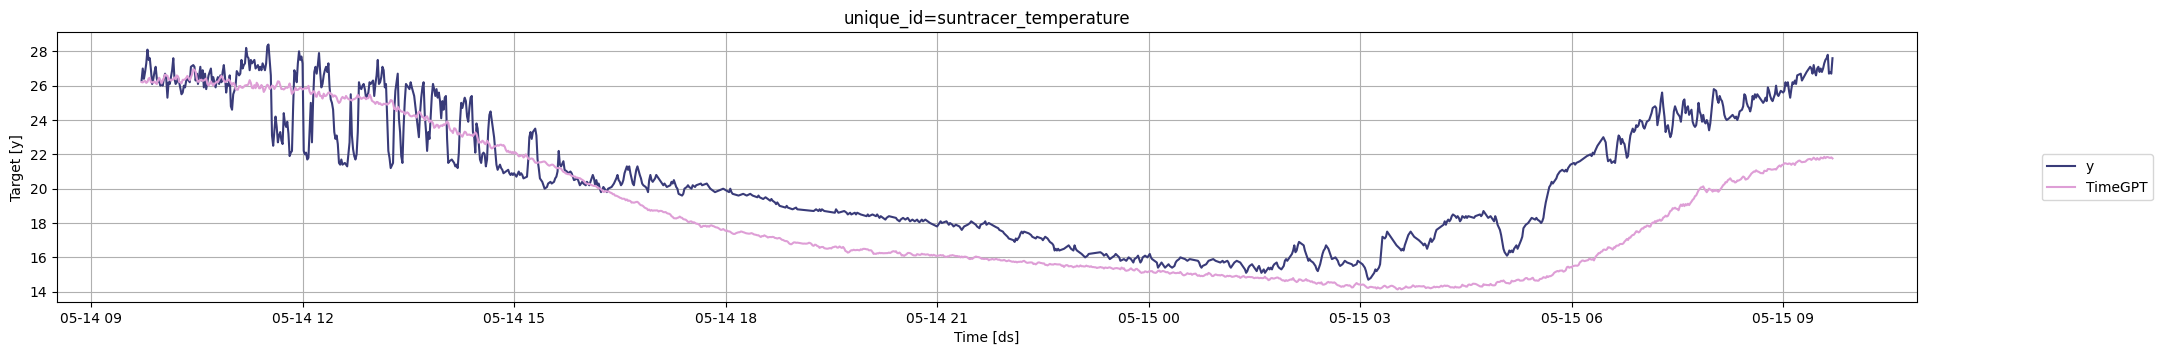

In [375]:
nixtla_client.plot(test_without_gaps_df, forecast_with_gaps, time_col='ds', target_col='y')

In [376]:
# Evaluate the model
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae

In [380]:
forecast_with_gaps['ds'] = pd.to_datetime(forecast_with_gaps['ds'])

results = test_without_gaps_df.merge(forecast_with_gaps, on=['ds', 'unique_id'], how='left')
results.tail()

,unique_id,ds,y,TimeGPT
1435,suntracer_temperature,2023-05-15 09:38:00,27.8,21.842564
1436,suntracer_temperature,2023-05-15 09:39:00,26.7,21.810488
1437,suntracer_temperature,2023-05-15 09:40:00,26.8,21.790310
1438,suntracer_temperature,2023-05-15 09:41:00,26.7,21.823784
1439,suntracer_temperature,2023-05-15 09:42:00,27.6,21.765404


In [378]:
evaluate(results, metrics=[mae])

,unique_id,metric,TimeGPT
0,suntracer_temperature,mae,2.18703
